# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

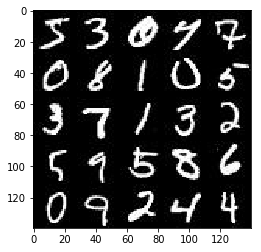

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

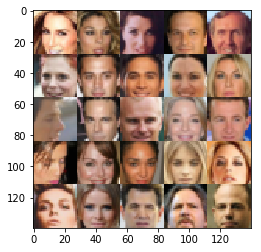

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/Applications/anaconda/envs/face_generation/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Applications/anaconda/envs/face_generation/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Applications/anaconda/envs/face_generation/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Applications/anaconda/envs/face_generation/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Applications/anaconda/envs/face_generation/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Applications/anaconda/envs/face_generation/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    i

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
# TODO: Add additional layers to this, since this probably doesn't work very well.

In [8]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*2048)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 2048))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 1024, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        #x3 = tf.layers.conv2d_transpose(x2, 56, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100, figsize=(5,5)):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    tf.reset_default_graph()
 
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,
                                data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tensor, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, 100))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_tensor: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, learning_rate_tensor: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, learning_rate_tensor: learning_rate})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2 Batch# 10... Discriminator Loss: 0.0053... Generator Loss: 6.1474
Epoch 1/2 Batch# 20... Discriminator Loss: 0.0054... Generator Loss: 5.7331
Epoch 1/2 Batch# 30... Discriminator Loss: 0.0246... Generator Loss: 4.2015
Epoch 1/2 Batch# 40... Discriminator Loss: 0.0650... Generator Loss: 4.0238
Epoch 1/2 Batch# 50... Discriminator Loss: 0.0319... Generator Loss: 21.8859
Epoch 1/2 Batch# 60... Discriminator Loss: 0.7958... Generator Loss: 4.6296


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 0.0121... Generator Loss: 16.6777
Epoch 1/1 Batch# 20... Discriminator Loss: 0.0549... Generator Loss: 4.9715
Epoch 1/1 Batch# 30... Discriminator Loss: 0.0034... Generator Loss: 21.2599
Epoch 1/1 Batch# 40... Discriminator Loss: 0.0529... Generator Loss: 37.0017
Epoch 1/1 Batch# 50... Discriminator Loss: 0.0407... Generator Loss: 36.9293
Epoch 1/1 Batch# 60... Discriminator Loss: 1.8700... Generator Loss: 0.5859
Epoch 1/1 Batch# 70... Discriminator Loss: 0.1601... Generator Loss: 4.3689
Epoch 1/1 Batch# 80... Discriminator Loss: 0.2198... Generator Loss: 13.5785
Epoch 1/1 Batch# 90... Discriminator Loss: 0.2587... Generator Loss: 2.0511
Epoch 1/1 Batch# 100... Discriminator Loss: 0.1747... Generator Loss: 3.3069


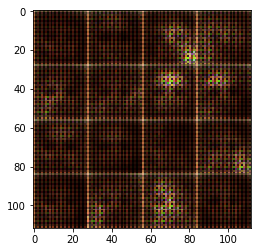

Epoch 1/1 Batch# 110... Discriminator Loss: 0.2233... Generator Loss: 2.3812
Epoch 1/1 Batch# 120... Discriminator Loss: 0.1364... Generator Loss: 2.6931
Epoch 1/1 Batch# 130... Discriminator Loss: 0.2553... Generator Loss: 7.3421
Epoch 1/1 Batch# 140... Discriminator Loss: 0.0143... Generator Loss: 5.8424
Epoch 1/1 Batch# 150... Discriminator Loss: 0.0319... Generator Loss: 4.2969
Epoch 1/1 Batch# 160... Discriminator Loss: 0.0111... Generator Loss: 6.5252
Epoch 1/1 Batch# 170... Discriminator Loss: 0.0228... Generator Loss: 4.2670
Epoch 1/1 Batch# 180... Discriminator Loss: 0.0041... Generator Loss: 8.6098
Epoch 1/1 Batch# 190... Discriminator Loss: 0.0051... Generator Loss: 7.6919
Epoch 1/1 Batch# 200... Discriminator Loss: 0.0115... Generator Loss: 7.1570


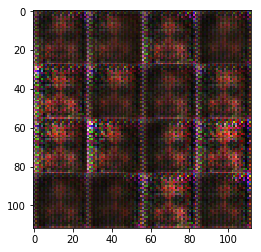

Epoch 1/1 Batch# 210... Discriminator Loss: 0.0324... Generator Loss: 3.8862
Epoch 1/1 Batch# 220... Discriminator Loss: 0.0123... Generator Loss: 8.4682
Epoch 1/1 Batch# 230... Discriminator Loss: 0.0234... Generator Loss: 4.6907
Epoch 1/1 Batch# 240... Discriminator Loss: 0.0119... Generator Loss: 7.2937
Epoch 1/1 Batch# 250... Discriminator Loss: 0.0143... Generator Loss: 5.1389
Epoch 1/1 Batch# 260... Discriminator Loss: 0.0043... Generator Loss: 7.5497
Epoch 1/1 Batch# 270... Discriminator Loss: 0.0533... Generator Loss: 11.4373
Epoch 1/1 Batch# 280... Discriminator Loss: 0.2330... Generator Loss: 4.4167
Epoch 1/1 Batch# 290... Discriminator Loss: 0.1732... Generator Loss: 2.7772
Epoch 1/1 Batch# 300... Discriminator Loss: 0.1996... Generator Loss: 3.1064


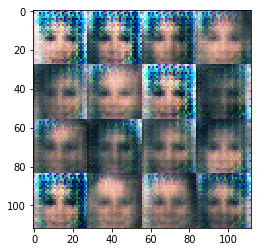

Epoch 1/1 Batch# 310... Discriminator Loss: 0.0814... Generator Loss: 3.6000
Epoch 1/1 Batch# 320... Discriminator Loss: 0.0419... Generator Loss: 3.9602
Epoch 1/1 Batch# 330... Discriminator Loss: 0.0477... Generator Loss: 8.8024
Epoch 1/1 Batch# 340... Discriminator Loss: 0.0537... Generator Loss: 3.6253
Epoch 1/1 Batch# 350... Discriminator Loss: 0.0068... Generator Loss: 6.0978
Epoch 1/1 Batch# 360... Discriminator Loss: 0.0101... Generator Loss: 6.9540
Epoch 1/1 Batch# 370... Discriminator Loss: 0.0025... Generator Loss: 7.9740
Epoch 1/1 Batch# 380... Discriminator Loss: 0.0327... Generator Loss: 5.1488
Epoch 1/1 Batch# 390... Discriminator Loss: 0.0065... Generator Loss: 9.1651
Epoch 1/1 Batch# 400... Discriminator Loss: 0.0063... Generator Loss: 8.4978


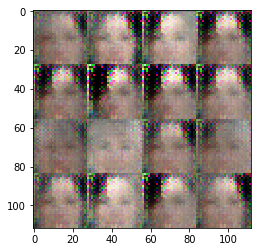

Epoch 1/1 Batch# 410... Discriminator Loss: 0.0105... Generator Loss: 9.7379
Epoch 1/1 Batch# 420... Discriminator Loss: 0.0078... Generator Loss: 11.6306
Epoch 1/1 Batch# 430... Discriminator Loss: 0.7363... Generator Loss: 1.5016
Epoch 1/1 Batch# 440... Discriminator Loss: 0.0549... Generator Loss: 6.0801
Epoch 1/1 Batch# 450... Discriminator Loss: 0.0242... Generator Loss: 6.1656
Epoch 1/1 Batch# 460... Discriminator Loss: 0.0057... Generator Loss: 9.6756
Epoch 1/1 Batch# 470... Discriminator Loss: 0.0030... Generator Loss: 11.2142
Epoch 1/1 Batch# 480... Discriminator Loss: 0.0155... Generator Loss: 7.5771
Epoch 1/1 Batch# 490... Discriminator Loss: 4.7898... Generator Loss: 8.7941
Epoch 1/1 Batch# 500... Discriminator Loss: 0.5379... Generator Loss: 2.1304


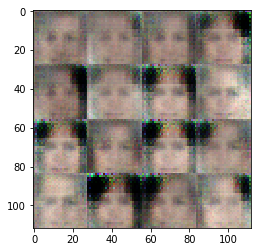

Epoch 1/1 Batch# 510... Discriminator Loss: 0.1034... Generator Loss: 5.7559
Epoch 1/1 Batch# 520... Discriminator Loss: 0.0357... Generator Loss: 5.7874
Epoch 1/1 Batch# 530... Discriminator Loss: 0.0823... Generator Loss: 5.8666
Epoch 1/1 Batch# 540... Discriminator Loss: 0.0649... Generator Loss: 3.5491
Epoch 1/1 Batch# 550... Discriminator Loss: 0.0172... Generator Loss: 4.8419
Epoch 1/1 Batch# 560... Discriminator Loss: 0.0043... Generator Loss: 8.0734
Epoch 1/1 Batch# 570... Discriminator Loss: 0.0187... Generator Loss: 7.5712
Epoch 1/1 Batch# 580... Discriminator Loss: 0.0178... Generator Loss: 6.9833
Epoch 1/1 Batch# 590... Discriminator Loss: 0.0134... Generator Loss: 5.3942
Epoch 1/1 Batch# 600... Discriminator Loss: 0.0114... Generator Loss: 7.4664


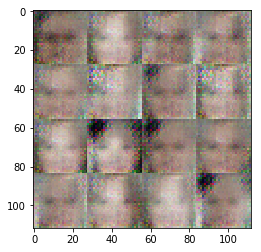

Epoch 1/1 Batch# 610... Discriminator Loss: 0.0129... Generator Loss: 5.6813
Epoch 1/1 Batch# 620... Discriminator Loss: 0.0093... Generator Loss: 6.1100
Epoch 1/1 Batch# 630... Discriminator Loss: 0.0081... Generator Loss: 5.7973
Epoch 1/1 Batch# 640... Discriminator Loss: 0.0279... Generator Loss: 4.7725
Epoch 1/1 Batch# 650... Discriminator Loss: 0.0050... Generator Loss: 6.6701
Epoch 1/1 Batch# 660... Discriminator Loss: 0.0127... Generator Loss: 8.0674
Epoch 1/1 Batch# 670... Discriminator Loss: 0.0419... Generator Loss: 5.8049
Epoch 1/1 Batch# 680... Discriminator Loss: 0.0269... Generator Loss: 4.8169
Epoch 1/1 Batch# 690... Discriminator Loss: 3.7694... Generator Loss: 9.3638
Epoch 1/1 Batch# 700... Discriminator Loss: 0.5082... Generator Loss: 2.0927


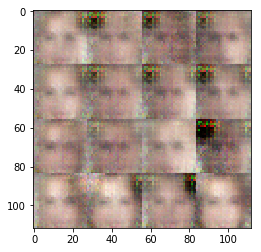

Epoch 1/1 Batch# 710... Discriminator Loss: 0.3279... Generator Loss: 2.4278
Epoch 1/1 Batch# 720... Discriminator Loss: 0.1974... Generator Loss: 3.0037
Epoch 1/1 Batch# 730... Discriminator Loss: 0.0819... Generator Loss: 3.8184
Epoch 1/1 Batch# 740... Discriminator Loss: 0.0991... Generator Loss: 3.6410
Epoch 1/1 Batch# 750... Discriminator Loss: 0.0503... Generator Loss: 5.8340
Epoch 1/1 Batch# 760... Discriminator Loss: 3.1419... Generator Loss: 0.1076
Epoch 1/1 Batch# 770... Discriminator Loss: 0.0999... Generator Loss: 3.8914
Epoch 1/1 Batch# 780... Discriminator Loss: 0.0879... Generator Loss: 3.3184
Epoch 1/1 Batch# 790... Discriminator Loss: 0.2287... Generator Loss: 2.3149
Epoch 1/1 Batch# 800... Discriminator Loss: 0.0748... Generator Loss: 3.1717


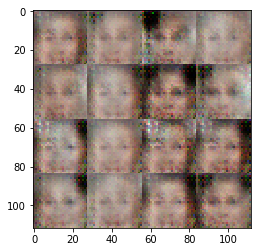

Epoch 1/1 Batch# 810... Discriminator Loss: 0.0574... Generator Loss: 3.5309
Epoch 1/1 Batch# 820... Discriminator Loss: 0.0038... Generator Loss: 12.7291
Epoch 1/1 Batch# 830... Discriminator Loss: 0.0970... Generator Loss: 3.7078
Epoch 1/1 Batch# 840... Discriminator Loss: 0.0486... Generator Loss: 6.7443
Epoch 1/1 Batch# 850... Discriminator Loss: 0.0521... Generator Loss: 4.3674
Epoch 1/1 Batch# 860... Discriminator Loss: 0.0064... Generator Loss: 6.8708
Epoch 1/1 Batch# 870... Discriminator Loss: 0.0245... Generator Loss: 5.0271
Epoch 1/1 Batch# 880... Discriminator Loss: 0.0289... Generator Loss: 4.8777
Epoch 1/1 Batch# 890... Discriminator Loss: 0.0078... Generator Loss: 7.0757
Epoch 1/1 Batch# 900... Discriminator Loss: 0.0404... Generator Loss: 4.6411


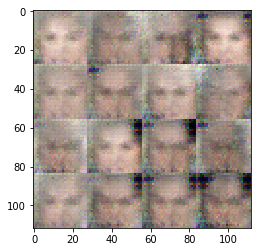

Epoch 1/1 Batch# 910... Discriminator Loss: 0.0058... Generator Loss: 7.3210
Epoch 1/1 Batch# 920... Discriminator Loss: 0.0169... Generator Loss: 6.0920
Epoch 1/1 Batch# 930... Discriminator Loss: 0.0063... Generator Loss: 7.6924
Epoch 1/1 Batch# 940... Discriminator Loss: 0.0032... Generator Loss: 7.9148
Epoch 1/1 Batch# 950... Discriminator Loss: 0.0055... Generator Loss: 6.1867
Epoch 1/1 Batch# 960... Discriminator Loss: 0.0169... Generator Loss: 5.1070
Epoch 1/1 Batch# 970... Discriminator Loss: 0.0176... Generator Loss: 5.2351
Epoch 1/1 Batch# 980... Discriminator Loss: 0.0091... Generator Loss: 9.9123
Epoch 1/1 Batch# 990... Discriminator Loss: 0.0179... Generator Loss: 5.0668
Epoch 1/1 Batch# 1000... Discriminator Loss: 0.0071... Generator Loss: 6.5615


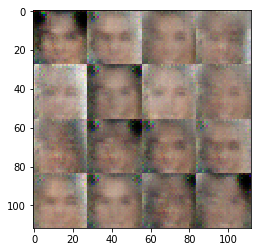

Epoch 1/1 Batch# 1010... Discriminator Loss: 0.0160... Generator Loss: 9.8279
Epoch 1/1 Batch# 1020... Discriminator Loss: 0.0104... Generator Loss: 6.1545
Epoch 1/1 Batch# 1030... Discriminator Loss: 0.0369... Generator Loss: 5.1132
Epoch 1/1 Batch# 1040... Discriminator Loss: 0.0074... Generator Loss: 6.1149
Epoch 1/1 Batch# 1050... Discriminator Loss: 0.0051... Generator Loss: 9.4481
Epoch 1/1 Batch# 1060... Discriminator Loss: 0.0163... Generator Loss: 5.0711
Epoch 1/1 Batch# 1070... Discriminator Loss: 0.0155... Generator Loss: 5.3326
Epoch 1/1 Batch# 1080... Discriminator Loss: 0.0080... Generator Loss: 5.4685
Epoch 1/1 Batch# 1090... Discriminator Loss: 2.7897... Generator Loss: 0.8937
Epoch 1/1 Batch# 1100... Discriminator Loss: 0.9452... Generator Loss: 1.6550


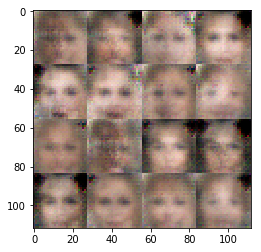

Epoch 1/1 Batch# 1110... Discriminator Loss: 1.2118... Generator Loss: 1.7728
Epoch 1/1 Batch# 1120... Discriminator Loss: 1.4342... Generator Loss: 0.7498
Epoch 1/1 Batch# 1130... Discriminator Loss: 1.0254... Generator Loss: 0.9646
Epoch 1/1 Batch# 1140... Discriminator Loss: 0.7475... Generator Loss: 2.0622
Epoch 1/1 Batch# 1150... Discriminator Loss: 0.7085... Generator Loss: 1.5756
Epoch 1/1 Batch# 1160... Discriminator Loss: 0.1941... Generator Loss: 3.3189
Epoch 1/1 Batch# 1170... Discriminator Loss: 0.0437... Generator Loss: 4.9444
Epoch 1/1 Batch# 1180... Discriminator Loss: 0.0740... Generator Loss: 4.4402
Epoch 1/1 Batch# 1190... Discriminator Loss: 0.0143... Generator Loss: 6.8873
Epoch 1/1 Batch# 1200... Discriminator Loss: 0.0285... Generator Loss: 5.2940


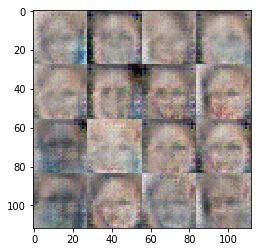

Epoch 1/1 Batch# 1210... Discriminator Loss: 0.0174... Generator Loss: 6.6570
Epoch 1/1 Batch# 1220... Discriminator Loss: 0.0729... Generator Loss: 3.9300
Epoch 1/1 Batch# 1230... Discriminator Loss: 0.0404... Generator Loss: 4.3638
Epoch 1/1 Batch# 1240... Discriminator Loss: 0.0123... Generator Loss: 5.5709
Epoch 1/1 Batch# 1250... Discriminator Loss: 0.0094... Generator Loss: 6.2508
Epoch 1/1 Batch# 1260... Discriminator Loss: 0.0075... Generator Loss: 6.8267
Epoch 1/1 Batch# 1270... Discriminator Loss: 0.0015... Generator Loss: 10.8612
Epoch 1/1 Batch# 1280... Discriminator Loss: 0.0245... Generator Loss: 4.9885
Epoch 1/1 Batch# 1290... Discriminator Loss: 0.0103... Generator Loss: 5.9588
Epoch 1/1 Batch# 1300... Discriminator Loss: 0.0132... Generator Loss: 5.9318


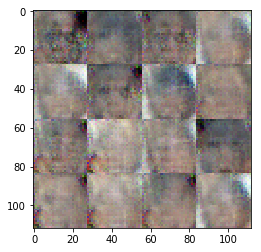

Epoch 1/1 Batch# 1310... Discriminator Loss: 0.0276... Generator Loss: 5.4383
Epoch 1/1 Batch# 1320... Discriminator Loss: 0.0065... Generator Loss: 6.8025
Epoch 1/1 Batch# 1330... Discriminator Loss: 0.0067... Generator Loss: 6.5371
Epoch 1/1 Batch# 1340... Discriminator Loss: 0.1313... Generator Loss: 3.4180
Epoch 1/1 Batch# 1350... Discriminator Loss: 0.0069... Generator Loss: 14.3227
Epoch 1/1 Batch# 1360... Discriminator Loss: 0.0137... Generator Loss: 8.1388
Epoch 1/1 Batch# 1370... Discriminator Loss: 0.0095... Generator Loss: 11.2332
Epoch 1/1 Batch# 1380... Discriminator Loss: 0.0011... Generator Loss: 11.1243
Epoch 1/1 Batch# 1390... Discriminator Loss: 0.0082... Generator Loss: 6.0209
Epoch 1/1 Batch# 1400... Discriminator Loss: 0.0446... Generator Loss: 4.0736


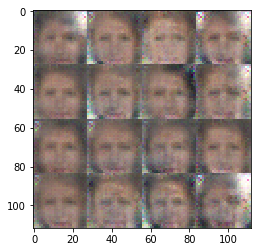

Epoch 1/1 Batch# 1410... Discriminator Loss: 0.0063... Generator Loss: 12.7132
Epoch 1/1 Batch# 1420... Discriminator Loss: 0.0240... Generator Loss: 4.4547
Epoch 1/1 Batch# 1430... Discriminator Loss: 0.0469... Generator Loss: 6.7870


IndexError: list index out of range

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.